In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Algorytm genetyczny to metoda optymalizacji inspirowana procesami ewolucyjnymi w przyrodzie, takimi jak dobór naturalny i dziedziczenie. Celem  algorytmu jest znalezienie możliwie najlepszego rozwiązania danego problemu – w tym przypadku problemu komiwojażera, czyli znalezienia najkrótszej możliwej trasy odwiedzającej wszystkie miasta dokładnie raz i wracającej do punktu startowego.

**Ogólny przebieg algorytmu**

1. Inicjalizacja
<br> Tworzona jest losowa populacja początkowa, czyli zestaw możliwych tras (rozwiązań).

2. Ocena populacji
<br> Każdy osobnik (czyli trasa) oceniany jest na podstawie długości trasy. Im krótsza trasa, tym lepsza jakość.

3. Selekcja
<br> Z populacji wybierani są rodzice do reprodukcji. W zależności od wybranej metody selekcji (ruletka z grupowaniem lub lista rankingowa), lepsze osobniki mają większe szanse na bycie wybranym.

4. Krzyżowanie (tzw. uporządkowane crossover)
<br> Wybrani rodzice są krzyżowani (łączone są ich losowo wybrane cechy) z określonym prawdopodobieństwem, tworząc nowe trasy.

5. Mutacja (tzw. mutacja inwersyjna) 
<br> Niektóre nowe trasy są losowo zmieniane (przez inwersję losowego odcinka).

6. Elityzm
<br> Najlepszy osobnik z poprzedniej generacji może zostać bez zmian przeniesiony do nowej populacji (jeśli parametr elite_size > 0).

7. Warunek stopu
<br> Proces powtarzany jest przez ustaloną liczbę generacji lub do spełnienia określonego kryterium zakończenia.

**Parametry algorytmu**
- **num_cities**: liczba miast w problemie 
- **pop_size**: liczebność populacji 
- **num_generations**: ile generacji (pokoleń) ma zostać wygenerowanych
- **crossover_prob**: prawdopodobieństwo wykonania krzyżowania 
- **mutation_prob**: początkowe prawdopodobieństwo mutacji
- **elite_size**: liczba najlepszych osobników, którzy są kopiowani bez zmian do kolejnej generacji (elityzm)
- **method**: metoda selekcji – dostępne opcje:
    - 'grouped_roulette' – ruletka z grupowaniem (lepsze osobniki mają większą szansę na wybór, proporcjonalnie do swojej jakości)
    - 'ranking_list' – lista rankingowa (wybieranie z najlepszych 30% osobników)
- **a, b**: współczynniki sterujące prawdopodobieństwem wyboru w metodzie ruletki z grupowaniem
- **use_circle**: jeśli True, miasta rozmieszczone są na okręgu

In [2]:
def run_genetic_algorithm(
    num_cities=30,
    pop_size=100,
    method='grouped_roulette',  # 'ranking_list' lub 'grouped_roulette'
    crossover_prob=0.9,
    mutation_prob=0.04,
    num_generations=300,
    elite_size=1,
    seed=42,
    use_circle=False,
    a=0.2,  # parametr dla grouped_roulette
    b=0.8   # parametr dla grouped_roulette
):

    random.seed(seed)
    np.random.seed(seed)

     # generowanie miast na okręgu (jeśli wybrano use_circle=True)
    def generate_cities_on_circle(radius=150, center=(150, 150)):
        angles = np.sort(np.random.rand(num_cities) * 2 * np.pi)
        return np.array([
            (
                center[0] + radius * np.cos(angle),
                center[1] + radius * np.sin(angle)
            )
            for angle in angles
        ])

    # współrzędne miast: losowe (use_circle=False) lub na okręgu (use_circle=True)
    cities = generate_cities_on_circle() if use_circle else np.random.rand(num_cities, 2) * 300

    # obliczanie odległości między dwoma miastami
    def euclidean_distance(a, b):
        return np.linalg.norm(a - b)

    # suma odległości dla całej trasy
    def total_distance(route):
        return sum(euclidean_distance(cities[route[i]], cities[route[(i + 1) % num_cities]]) for i in range(num_cities))

    # tworzenie początkowej populacji 
    def create_initial_population():
        return [random.sample(range(num_cities), num_cities) for _ in range(pop_size)]

    # ocena populacji – sortowanie według długości trasy
    def rank_population(population):
        evaluated = [(ind, total_distance(ind)) for ind in population]
        return sorted(evaluated, key=lambda x: x[1])

    # selekcja: metoda ruletki z normalizacją
    def selection_grouped_roulette(ranked):
        dists = np.array([dist for _, dist in ranked])
        best_dist = np.min(dists)
        worst_dist = np.max(dists)
    
        normalized = (worst_dist - dists) / (worst_dist - best_dist + 1e-9)  # epsilon, żeby uniknąć dzielenia przez 0
    
        fitness = a + b * normalized
        fitness_sum = np.sum(fitness)
        probabilities = fitness / fitness_sum
    
        selected_idx = np.random.choice(len(ranked), p=probabilities)
        return ranked[selected_idx][0]

    # główna funkcja selekcji - w zależności od wybranej metody
    def selection(ranked, method):
        if method == 'ranking_list':  # selekcja: metoda prosta - lista rankingowa
            cutoff = int(len(ranked) * 0.3)  # 30% najlepszych
            top_individuals = ranked[:cutoff]
            return random.choice(top_individuals)[0]
        elif method == 'grouped_roulette':   # selekcja: metoda ruletki
            return selection_grouped_roulette(ranked)
        else:
            raise ValueError("Unknown selection method. Use 'ranking_list' or 'grouped_roulette'.")

    # KRZYŻOWANIE - tzw. uporządkowane crossover       
    def crossover(parent1, parent2, crossover_rate):
        if random.random() > crossover_rate:
            return parent1[:]  #bez krzyżowania zwraca kopię rodzica1
    
        start, end = sorted(random.sample(range(len(parent1)), 2))
        
        # kopiowanie fragmentu z parent1
        child = [-1] * len(parent1)
        child[start:end + 1] = parent1[start:end + 1]
    
        # wypełnienie reszty kolejno z parent2
        pointer_parent2 = 0
        pointer_child = 0
    
        while -1 in child:
            if parent2[pointer_parent2] not in child:  # tylko jeśli nie ma już w dziecku
                while child[pointer_child] != -1:
                    pointer_child += 1
                child[pointer_child] = parent2[pointer_parent2]
            pointer_parent2 += 1
    
        return child

    # MUTACJIA – zamiana dwóch miast miejscami
    def mutate(individual, mutation_rate):
        if random.random() < mutation_rate:
            i, j = sorted(random.sample(range(len(individual)), 2))
            individual[i:j] = reversed(individual[i:j])
        return individual


    
    # tworzenie nowej generacji
    def next_generation(current_pop):
        ranked = rank_population(current_pop)
        next_pop = [ind for ind, _ in ranked[:elite_size]] # zachowanie elity
        while len(next_pop) < pop_size:
            parent1 = selection(ranked, method)
            parent2 = selection(ranked, method)
            child = crossover(parent1, parent2, adaptive_crossover)
            child = mutate(child, adaptive_mutation)
            next_pop.append(child)
        return next_pop, ranked

    # rysowanie jednej trasy
    def plot_route_subplot(ax, route, generation):
        ax.scatter(cities[:, 0], cities[:, 1], color='black')
        path = cities[route + [route[0]]]
        ax.plot(path[:, 0], path[:, 1], color='skyblue', linewidth=2.5, label='Best')
        ax.set_title(f'Generation {generation}')
        ax.legend()
        ax.grid(True)

    # rysowanie wykresu zmian długości tras - wizualizacjia procesu optymalizacji
    def dist_plot(best_dists, avg_dists, worst_dists):
        plt.figure(figsize=(10, 5))
        plt.plot(best_dists, label='Best distance', color='blue', linewidth=2)
        plt.plot(avg_dists, label='Average distance', color='green', linestyle='--')
        plt.plot(worst_dists, label='Worst distance', color='red', linestyle=':')
        plt.xlabel('Generation')
        plt.ylabel('Distance')
        plt.title('Optimization Progress')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # główna pętla generacyjna
    population = create_initial_population()
    best_distances = []
    avg_distances = []
    worst_distances = []
    snapshots = []
    adaptive_mutation = mutation_prob
    adaptive_crossover = crossover_prob
    
    no_improvement_counter = 0
    best_overall = float('inf')

    for gen in range(num_generations):
        population, ranked = next_generation(population)
    
        distances = [dist for _, dist in ranked]
        current_best = min(distances)
        best_distances.append(current_best)
        avg_distances.append(np.mean(distances))
        worst_distances.append(max(distances))
    
        # adaptacyjne parametry mutacji i krzyżowania
        progress = gen / num_generations  
    
        adaptive_mutation = max(0.05, mutation_prob * (1 - 0.6 * progress))  
        adaptive_crossover = max(0.8, crossover_prob* (1 - 0.1 * progress))

        # zapisywanie najlepszych tras co 50 generacji w celu wizualizacji
        if gen % 50 == 0 or gen == num_generations - 1:
            snapshots.append((gen, ranked[0][0]))

    # wykresy tras
    cols = 3
    rows = -(-len(snapshots) // cols)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, (gen, best) in enumerate(snapshots):
        plot_route_subplot(axes[i], best, gen)

    for j in range(len(snapshots), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    dist_plot(best_distances, avg_distances, worst_distances) # wizualizacjia procesu optymalizacji


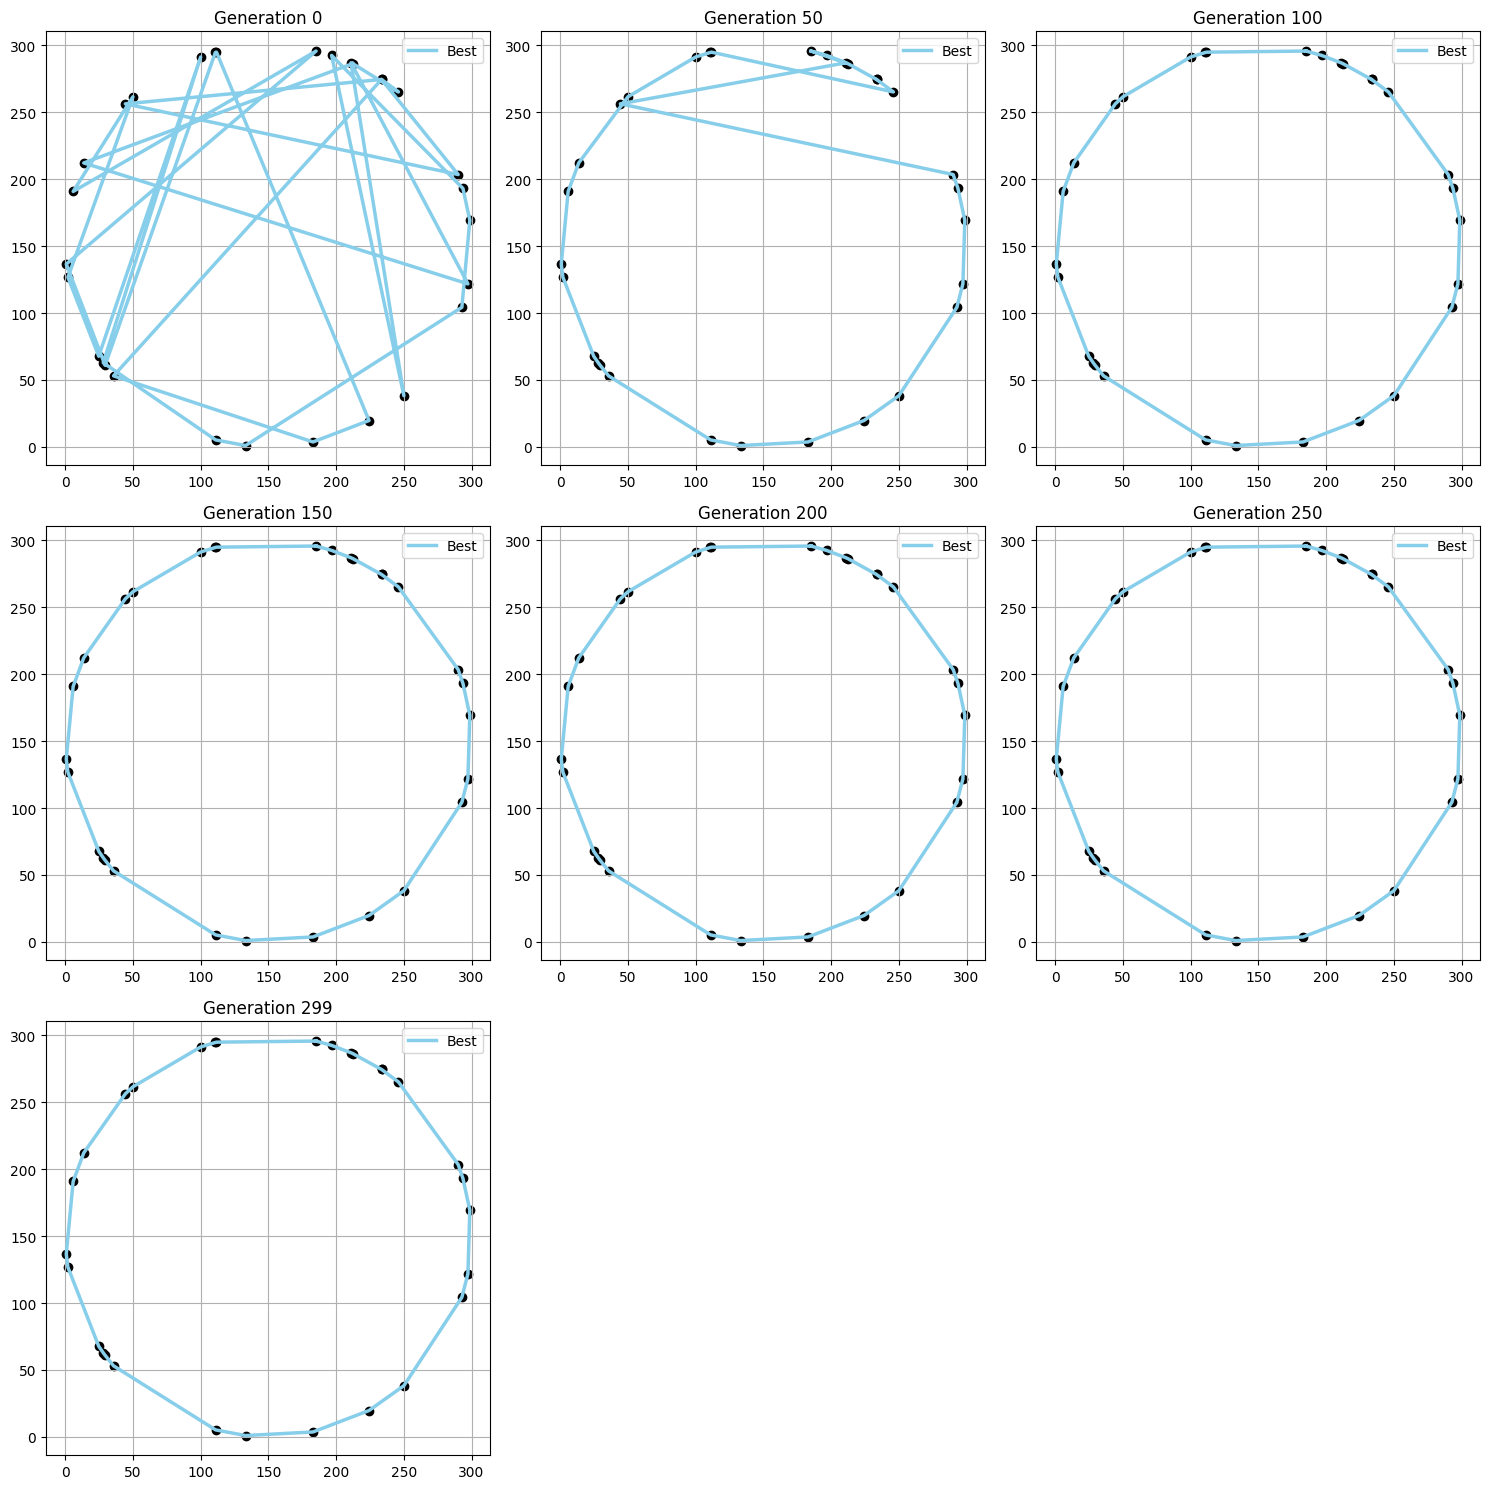

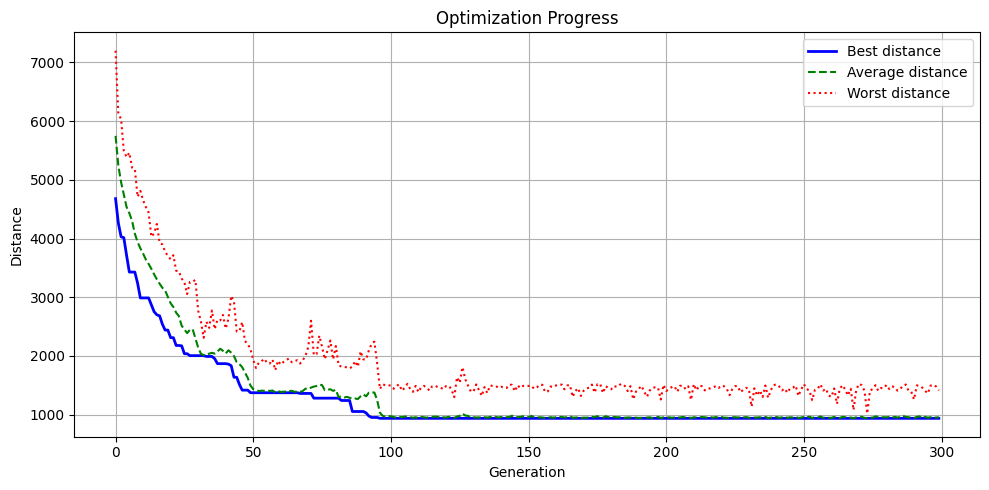

In [3]:
run_genetic_algorithm(num_cities=30, crossover_prob=0.94, mutation_prob=0.09, method='ranking_list', use_circle=True)

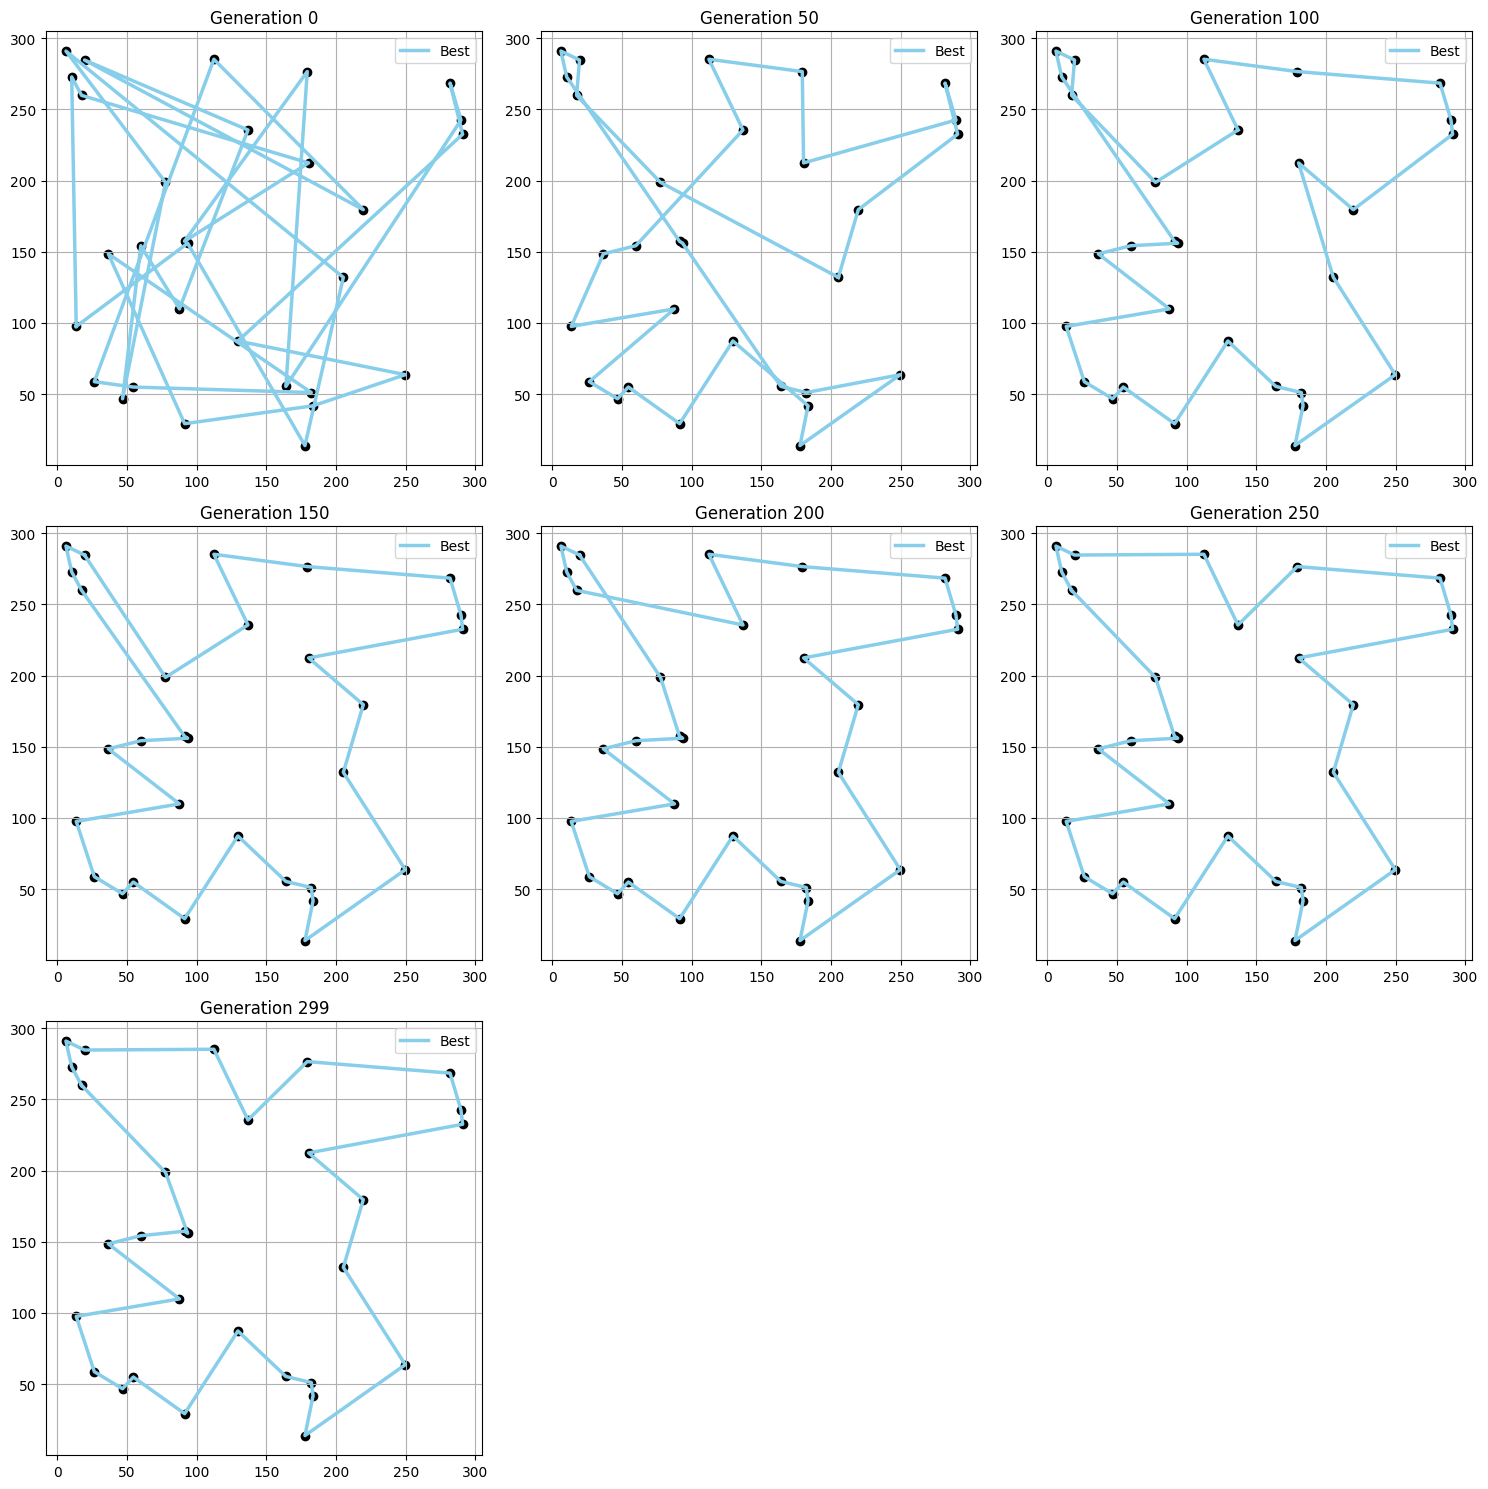

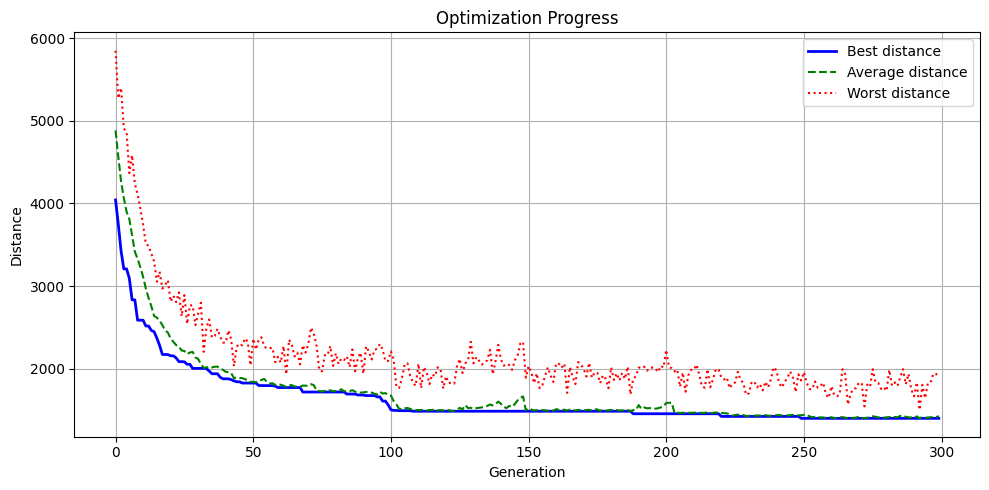

In [4]:
run_genetic_algorithm(num_cities=30, crossover_prob=0.95, mutation_prob=0.09, method='ranking_list')

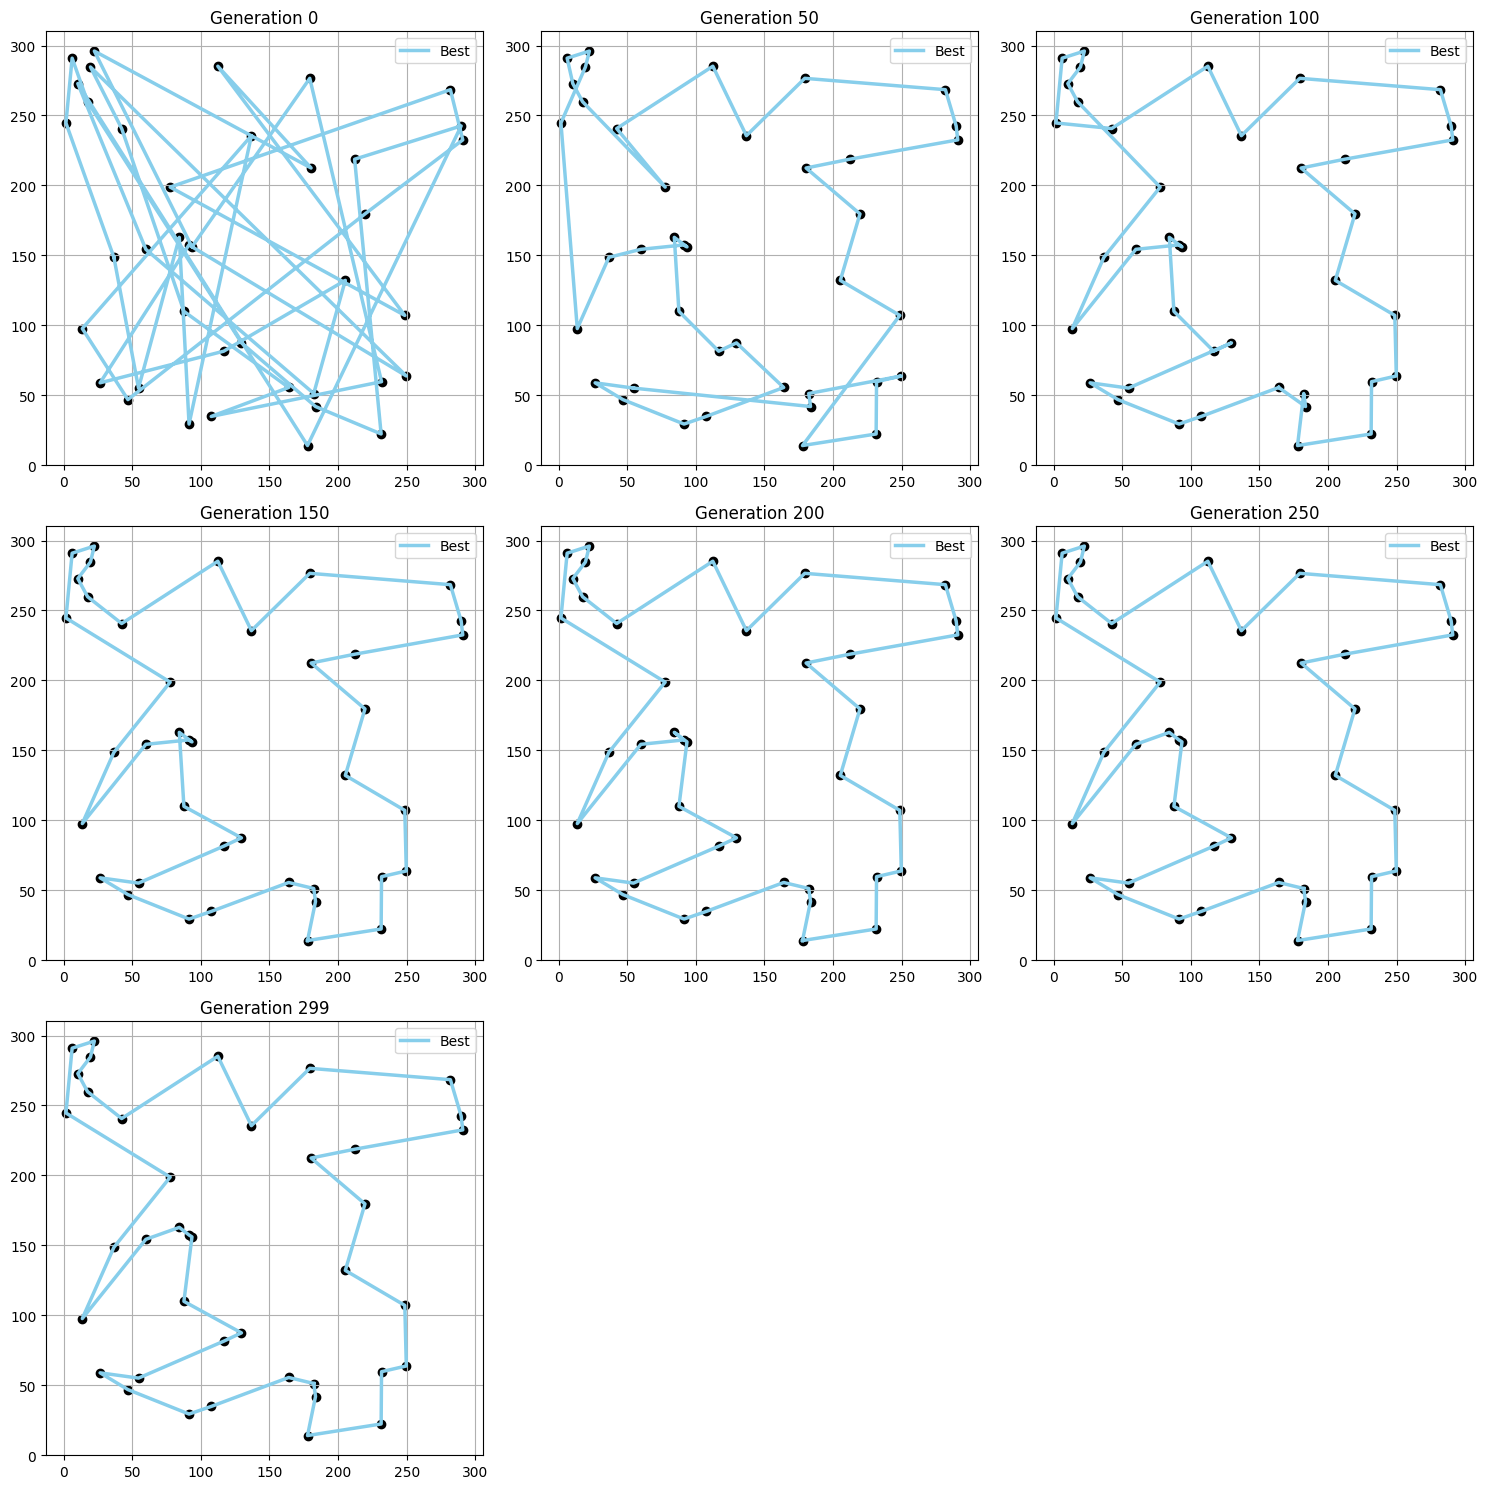

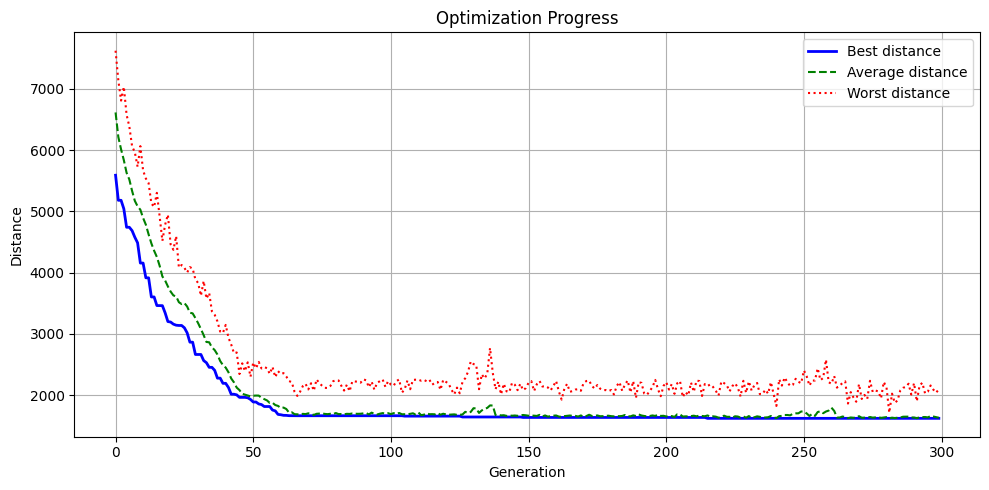

In [30]:
run_genetic_algorithm(num_cities=40, crossover_prob=0.94, mutation_prob=0.16, method='ranking_list')

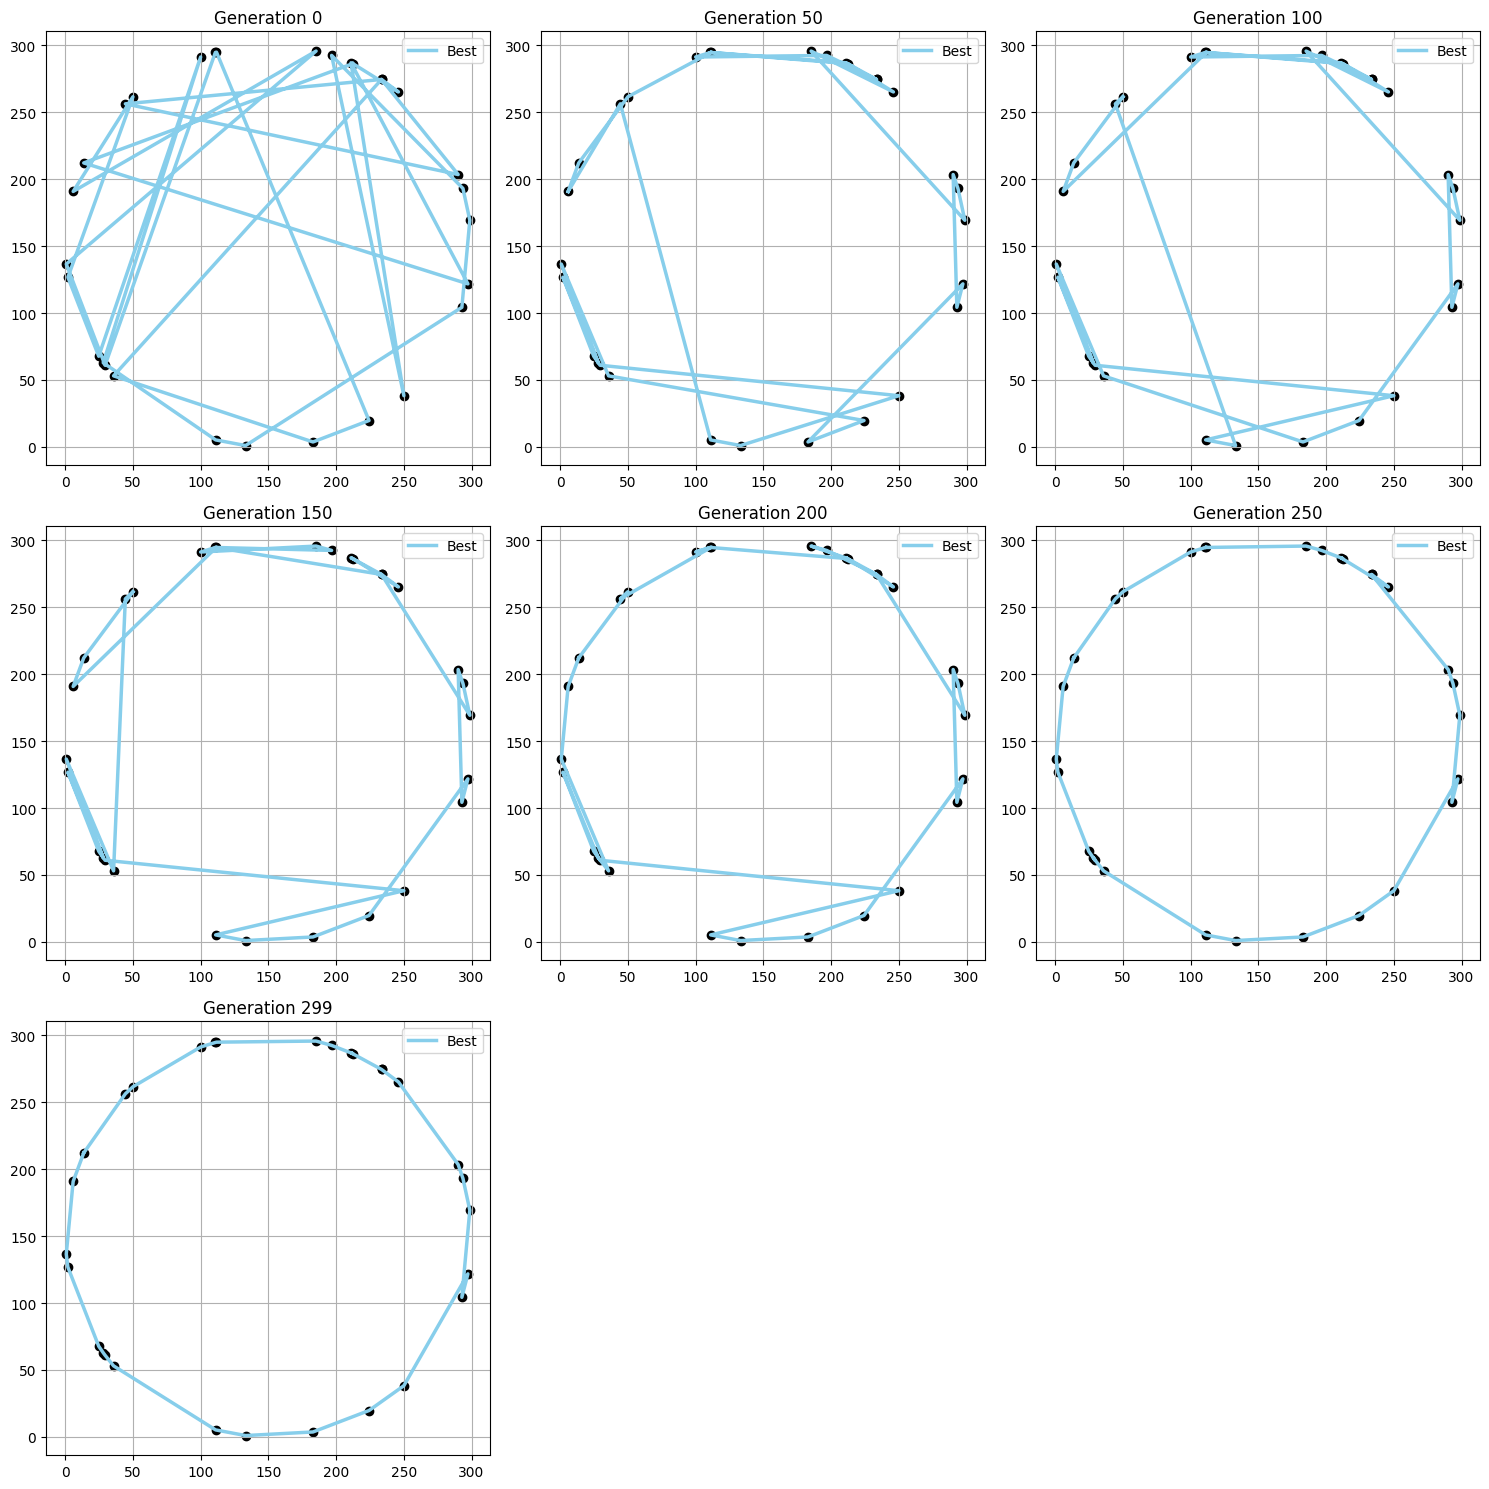

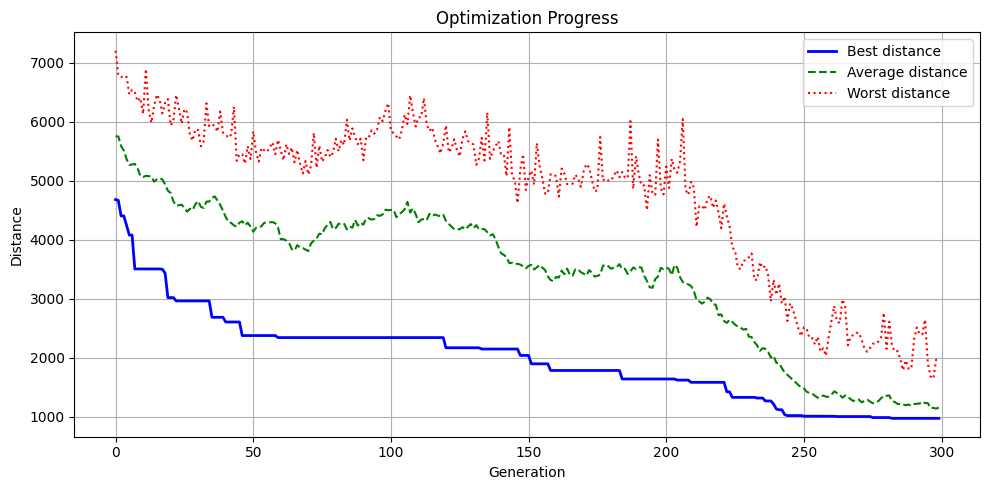

In [41]:
run_genetic_algorithm(num_cities=30, crossover_prob=0.91, mutation_prob=0.14, method='grouped_roulette', use_circle=True,b=0.7)

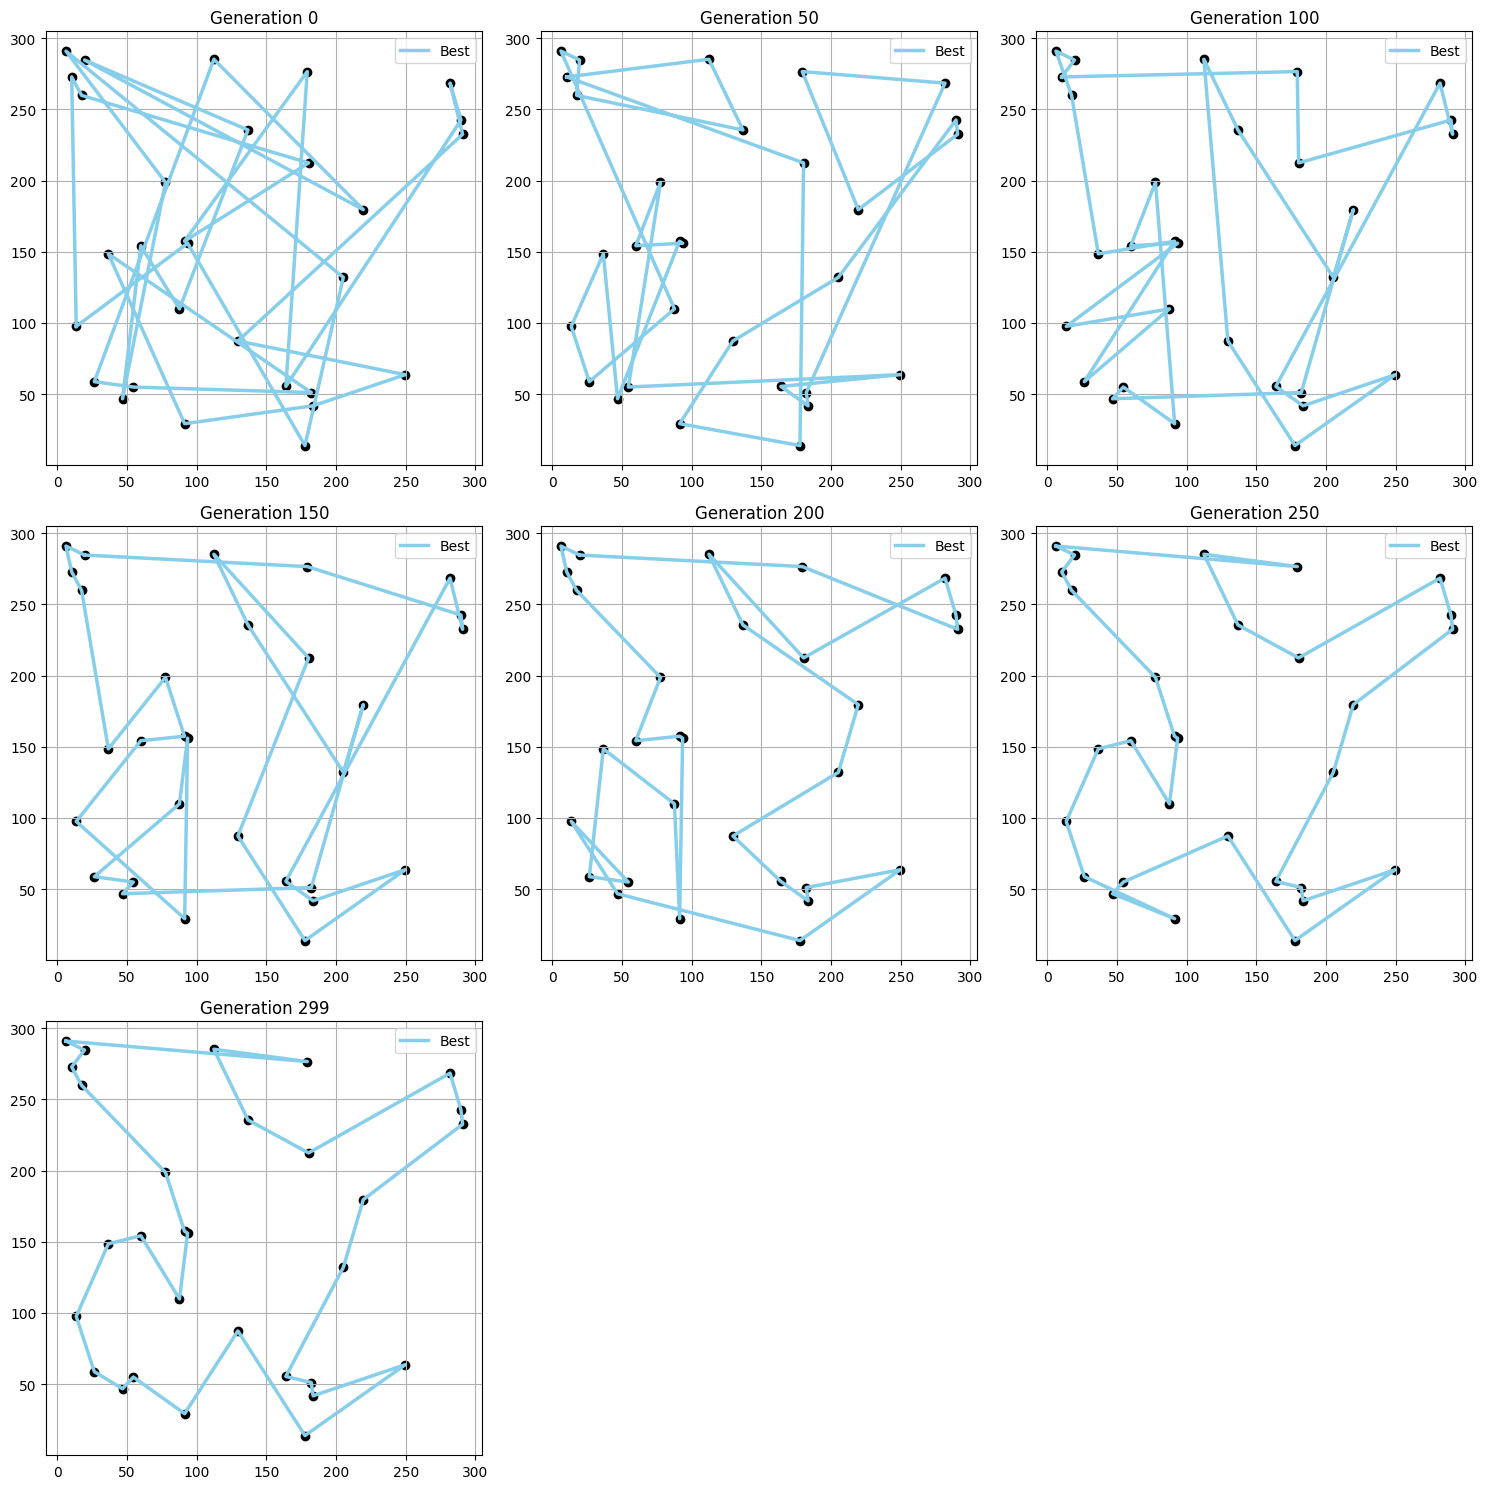

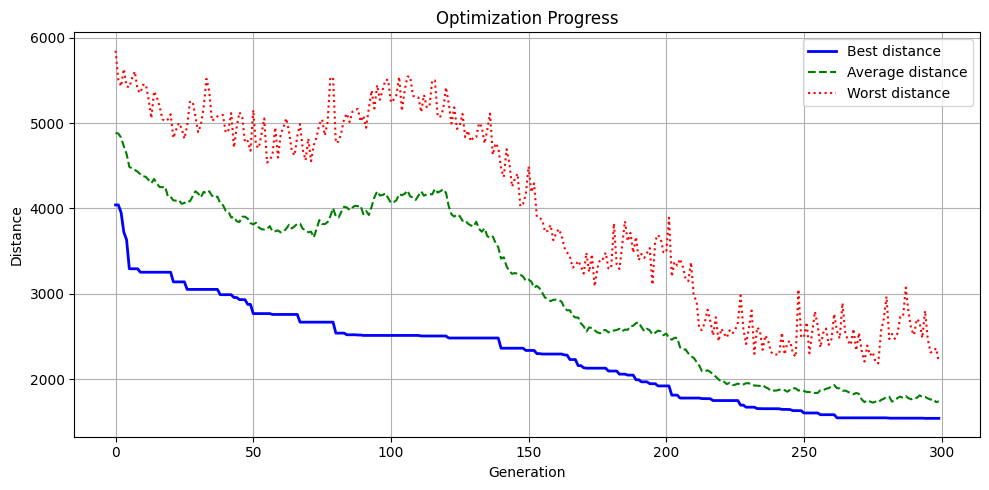

In [49]:
run_genetic_algorithm(num_cities=30, crossover_prob=0.93, mutation_prob=0.09, method='grouped_roulette',b=0.7)

**Interpretacja wykresów i ogólne obserwacje**

**Stała poprawa (optymalizacja)**
<br>Na wszystkich wykresach widać wyraźny spadek wartości funkcji dystansu (czyli całkowitego dystansu trasy) w kolejnych generacjach. Oznacza to, że algorytm genetyczny skutecznie optymalizuje rozwiązanie w czasie.

**Znalezienie trasy optymalnej**
<br>W przypadku parametrów:
- method='ranking_list'
- crossover_prob w zakresie 0.94–0.95
- mutation_prob w zakresie 0.09–0.16 (dla bardzi złożożonego problemu (więcej miast) - większy udział mutacji)

algorytm był w stanie znaleźć trasę optymalną, co objawia się stabilizacją wykresu "Best distance" (linia niebieska) na niskim poziomie i brakiem dalszych popraw po określonej liczbie generacji.

**Prawie optymalne trasy**
<br>Dla metody 'grouped_roulette' uzyskane wyniki były dobre, ale nie zawsze w pełni optymalne. Widać to po tym, że:
- najlepszy dystans (linia niebieska) nadal lekko się poprawia nawet w końcowych generacjach
- różnica między najlepszym a średnim/worst-case dystansem jest większa

**Wpływ parametrów i selekcji**
<br>Metoda 'ranking_list' wydaje się bardziej stabilna i łatwiejsza do strojeniа — uzyskiwała częściej optymalne rozwiązania nawet przy różnych liczbach miast.

Metoda 'grouped_roulette' wymaga dokładniejszego dopasowania parametrów, dlatego w celu znalezienia skutecznych ustawień parametrów, utworzono roboczą automatyczną pętlę testującą wszystkie kombinacje wartości crossover_prob i mutation_prob w ustalonych zakresach, mimo to otrzymane wyniki nie są w pełni optymalne.

**Wnioski końcowe**
- Selekcja 'ranking_list' wykazuje lepszą skuteczność w kontekście stabilności i szybkości dojścia do optimum.
- 'grouped_roulette' może dawać porównywalne wyniki, ale wymaga więcej eksperymentów z parametrami.
- W każdym przypadku widać, że algorytm stopniowo się uczy i poprawia rozwiązania, co potwierdza jego efektywność w problemie komiwojażera.

